# Imports

In [25]:
# project step 1
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import numpy as np

# project step 2
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from plotly.subplots import make_subplots
from xgboost import XGBClassifier
import plotly.graph_objs as gov
from sklearn.svm import SVC
import pickle

# Read in data

In [2]:
df = pd.read_csv('./Fraud.csv')

## Remap 'type' col to numeric

In [6]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [7]:
type_to_num = {'PAYMENT' : 0, 
               'TRANSFER' : 1, 
               'CASH_OUT' : 2, 
               'DEBIT' : 3, 
               'CASH_IN' : 4}

df['type'] = df['type'].map(type_to_num)
df.rename(columns={'oldbalanceOrg' : 'oldBalanceOrig',
                   'newbalanceOrig' : 'newBalanceOrig',
                   'oldbalanceDest' : 'oldBalanceDest',
                   'newbalanceDest' : 'newBalanceDest'}, inplace=True)

In [8]:
# sanity check

print(df['type'].unique())
print(df.head(5))
print(df.dtypes)

[0 1 2 3 4]
   step  type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1     0   9839.64  C1231006815        170136.0       160296.36   
1     1     0   1864.28  C1666544295         21249.0        19384.72   
2     1     1    181.00  C1305486145           181.0            0.00   
3     1     2    181.00   C840083671           181.0            0.00   
4     1     0  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
step                int64
type                int64
amount            float64
nameOrig           object
oldBala

# Project Step 2

# Down sample and Rebalance

In [ ]:
# separate df into 2 dfs based on target var
isFraud = df[df['isFraud'] == 1]
notFraud = df[df['isFraud'] == 0]

# random sample non-fraud w/ 10x the number of rows as fraud
resampled_df = notFraud.sample(n=10 * len(isFraud), random_state=1859)

# concat the 2 dfs together
balanced_df = pd.concat([isFraud, resampled_df])

# Baseline Model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906301
           1       0.00      0.00      0.00      2485

    accuracy                           1.00   1908786
   macro avg       0.50      0.50      0.50   1908786
weighted avg       1.00      1.00      1.00   1908786

[[1903891    2410]
 [   2481       4]]


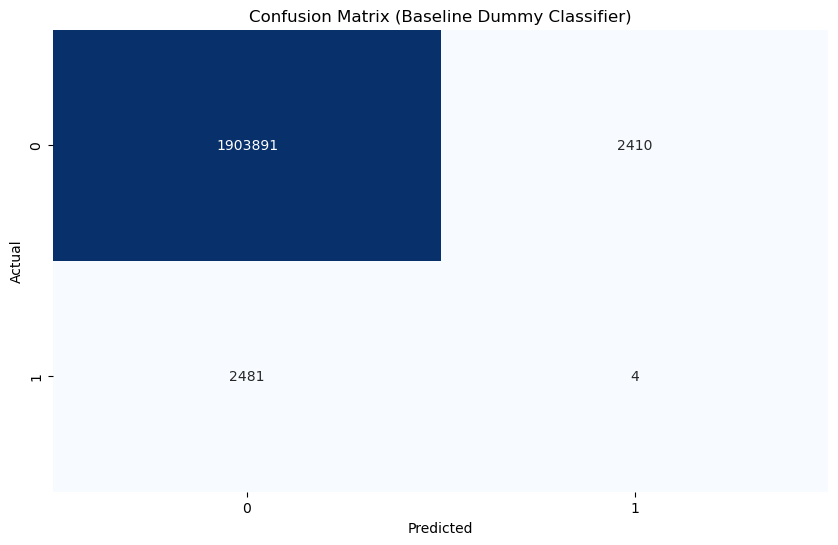

In [27]:
X = balanced_df.drop(columns=['nameOrig', 'nameDest','isFraud', 'isFlaggedFraud'])
y = balanced_df['isFraud']

# train-test 70-30 split (since heavily imbalanced)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1859)

# train baseline model (dummy classifier)
dummy_classifier = DummyClassifier(strategy='stratified') # using stratified since heavily imbalanced
dummy_classifier.fit(X_train, y_train)

# predict
y_pred = dummy_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

# create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Baseline Dummy Classifier)')
plt.show();

# Project Step 2

# Model Selection

## Compare Classifiers

In [28]:
# define stacked classifier
def base_models():
  models = dict()
  models['lr'] = LogisticRegression()
  models["KNN"] = KNeighborsClassifier()
  models["Tree"] = DecisionTreeClassifier()
  models["SVC"] = SVC()
  models["Gaussian"] = GaussianNB()
  models["RF"] = RandomForestClassifier()
  models["Bag"] = BaggingClassifier()
  models["GB"] = GradientBoostingClassifier()
  models["XGB"] = XGBClassifier()
  return models

# evaluate the list of models
def eval_models(model):
  cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1859) # reducing to 5x3 b/c taking WAAAAAY too long
  scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score=0)
  return scores

models = base_models()

# evaluate the models and store results
results, names = list(), list()

for name, model in models.items():
  scores = eval_models(model)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

classmod = pd.DataFrame(np.transpose(results), columns = ['lr', 'KNN', 'Tree', 'SVC', 'Gaussian', 'RF', 'Bag', 'GB', 'XGB'])
classmod = pd.melt(classmod.reset_index(), id_vars='index',value_vars=['lr', 'KNN', 'Tree', 'SVC', 'Gaussian', 'RF', 'Bag', 'GB', 'XGB'])

>lr 0.998 (0.000)


KeyboardInterrupt: 

In [ ]:
fig = px.box(classmod, x="variable", y="value",color="variable",points='all',
labels={"variable": "Machine Learning Model",
        "value": "Accuracy"
        },title="Model Performance")

file_path = '/content/drive/MyDrive/Colab Notebooks/hw2/boxplot1.html'
pyo.plot(fig, filename=file_path, auto_open=False)

fig.show();

In [ ]:
def eval_model_once(model):
  clf = model
  clf.fit(X_train, y_train)
  ypred = clf.predict(X_test)
  return ypred
models = base_models()

for name, model in models.items():
  y_pred = eval_model_once(model)
  conf_matrix = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(3, 3))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("{} Confusion Matrix".format(name))
  plt.show()



## Stacked Classifier

In [ ]:
def get_stacking():
	# define the base models
  level0 = list()
  level0.append(('RF', RandomForestClassifier()))
  level0.append(('Bagging', BaggingClassifier()))
  level0.append(('XGB', XGBClassifier()))
	# define meta learner model
  level1 = LogisticRegression()
	# define the stacking ensemble
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=2)
  return model

def base_models():
  model = dict()
  model["XGB"] = XGBClassifier()
  model["Random Forest"] = RandomForestClassifier()
  model["Bagging"] = BaggingClassifier()
  model["Stacked Model"] = get_stacking()
  return model

# Function to evaluate the list of models
def eval_models(model):
  cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=1859) # reducing to 3x5 b/c taking WAAAAAY too long
  scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1,
                            error_score=0)
  return scores

models = base_models()

In [ ]:
# evaluate the models and store results
results, names = list(), list()

for name, model in models.items():
  print("Working on {}".format(name))
  scores = eval_models(model)
  results.append(scores)
  names.append(name)
  print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

In [ ]:
classmod1 = pd.DataFrame(np.transpose(results), columns = ["XGB","Random Forest","Bagging","Stacked Classifier"])
classmod1 = pd.melt(classmod1.reset_index(), id_vars='index',value_vars=["XGB","Random Forest","Bagging","Stacked Classifier"])
classmod1.to_csv("/content/drive/MyDrive/Colab Notebooks/hw2/classmod1.csv")

fig = px.box(classmod1, x="variable", y="value",color="variable",points='all',
                labels={"variable": "Machine Learning Model",
                        "value": "Accuracy"
                        },title="Model Performance"
)
file_path = '/content/drive/MyDrive/Colab Notebooks/hw2/boxplot2.html'
pyo.plot(fig, filename=file_path, auto_open=False)

fig.show();

In [ ]:
level0 = list()
level0.append(('XGB', XGBClassifier()))
level0.append(('RF', RandomForestClassifier()))
level0.append(('Bagging', BaggingClassifier()))

level1 = LogisticRegression()
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=2)
model.fit(X_train, y_train)

## Pickle

In [ ]:
# Save to file in the current working directory
pkl_filename = "/content/drive/MyDrive/Colab Notebooks/hw2/hw2_pickle.pkl"

# save pickle file
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [ ]:
score = pickle_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Y_predict = pickle_model.predict(X_test)
predictions = pd.DataFrame(Y_predict, columns=['predictions'])
predictions['actual'] = y_test

In [ ]:
conf_matrix = confusion_matrix(y_test, predictions['predictions'])
print(conf_matrix)
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Stacked Model Confusion Matrix")
plt.show();